# Korišćenje modela

In [2]:
import pickle
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from keras.models import load_model
from keras.metrics import AUC
from keras import backend as K
import tensorflow as tf
import keras


### Učitavanje modela

In [3]:
with open('C:/Users/pc/Desktop/models/svm.model','rb') as file:
    svm = pickle.load(file)   

In [4]:
cnn = load_model('C:/Users/pc/Desktop/models/cnn.h5', custom_objects={"auc_1": keras.metrics.AUC})

### Učitavanje slika

In [5]:
imagePatches = glob.glob('C:/Users/pc/Desktop/10253/*/*.png', recursive=True) # ucitavamo putanje svih slika

In [6]:
len(imagePatches) # ukupan broj slika

549

In [7]:
# ucitavamo slike
imgs = []
width = 50
height = 50
for p in imagePatches:
    image = cv2.imread(p)
    imgs.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 

In [8]:
imgs = np.array(imgs)

In [9]:
# pravimo dataFrame koja sadrzi putanju slike, id pacijenta, x i y koordinate i ciljnu promenljivu
def extract_path(paths):
    d = {'path':[],'patient_id':[],'x_coord':[],'y_coord':[],'target':[]}
    for path in paths:
        d['path'].append(path)
        l = path.split('_')
        d['x_coord'].append(np.int(l[2][1:]))
        d['y_coord'].append(np.int(l[3][1:]))
        l1 = l[0].split('\\')
        d['patient_id'].append(np.int(l1[len(l1)-1]))
        d['target'].append(np.int(l1[len(l1)-2]))
    data = pd.DataFrame(d,columns = ['path','patient_id','x_coord','y_coord','target'])
    return data

In [10]:
data = extract_path(imagePatches)

In [11]:
data.head()

,path,patient_id,x_coord,y_coord,target
0,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1001,0
1,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1051,0
2,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1101,0
3,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1151,0
4,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1201,0


In [12]:
y = np.array(data['target'])

In [13]:
np.bincount(y)

array([479,  70], dtype=int64)

### Funkcije za crtanje slajdova

In [14]:
def CeoSlajdVizualizacija(patient_id, y_pred):
    
    # izdvajamo podatke vezane za pacijenta ciji slajd rekonstruisemo:
    data_patient = data[data['patient_id'] == patient_id]
    data_patient['x_coord'] = data_patient['x_coord'].astype(int)
    data_patient['y_coord'] = data_patient['y_coord'].astype(int)
    # izdvajamo najdalju tacku od koordinatnog pocetka:
    max_point = [data_patient['y_coord'].max()-1, data_patient['x_coord'].max()-1]
    # pravimo mrezu u koju cemo smestiti slajd kada slozimo sve male slike
    # dimenzije mreze moraju da budu takve da u nju mozemo da slozimo od najblize do najdalje male slike
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    # pravimo masku koju cemo staviti "preko slike", ona ce sadrzati lokacije tumora
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask_pred = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    
    # Ucitavamo sliku po sliku za naseg pacijenta
    for i in range(len(data_patient)):
        
            image = cv2.imread(data_patient.path.values[i])
            target = data_patient.target.values[i]
            target_pred = y_pred[i]
            
            x_coord = np.int(data_patient.x_coord.values[i])
            y_coord = np.int(data_patient.y_coord.values[i])
            # Koordinate od kojih pocinjemo smestanje slike u mrezu
            x_start = x_coord - 1
            y_start = y_coord - 1
            # Koordinate sa kojima zavrsavamo smestanje slike u mrezu
            x_end = x_start + 50
            y_end = y_start + 50
            # Smestamo sliku na njenu poziciju 
            grid[y_start:y_end, x_start:x_end] = image
            # Ako slika sadrzi tkivo zahvaceno tumorom maska ce na tim pozicijama imati vrednost vecu od 0
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if  target_pred == 1:
                mask_pred[y_start:y_end, x_start:x_end, 0] = 0
                mask_pred[y_start:y_end, x_start:x_end, 1] = 250
                mask_pred[y_start:y_end, x_start:x_end, 2] = 0
            

    return grid, mask, mask_pred

In [15]:
def plot_img(patient_id, y_pred):
    slajd, tumor, tumor_pred = CeoSlajdVizualizacija(patient_id, y_pred)
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(slajd, alpha=0.9) # parametar alfa kontrolise prozirnost slike
    ax[1].imshow(slajd, alpha=0.8)
    ax[1].imshow(tumor, alpha=0.7)
    ax[1].imshow(tumor_pred, alpha=0.6)
    ax[0].set_title("Snimak tkiva uzetog biopsijom")
    ax[1].set_title("Lokacija tumora: crveno - stvarna lokacija, zeleno - predvidjena lokacija")
    plt.show()

### Priprema slika 

In [16]:
imgs = imgs/255 # normalizacija slika

In [17]:
imgs_svm = imgs.reshape(imgs.shape[0],imgs.shape[1]*imgs.shape[2]*imgs.shape[3]) # svm model zahteva sliku u obliku jednodimenzionog vektora

In [18]:
img_pca = PCA(n_components = 244) # vrsimo redukciju dimenzija slike
imgs_svm = img_pca.fit_transform(imgs_svm)

### SVM

In [19]:
y_pred_svm = svm.predict(imgs_svm)

In [20]:
print(metrics.confusion_matrix(y,y_pred_svm))

[[220 259]
 [ 43  27]]


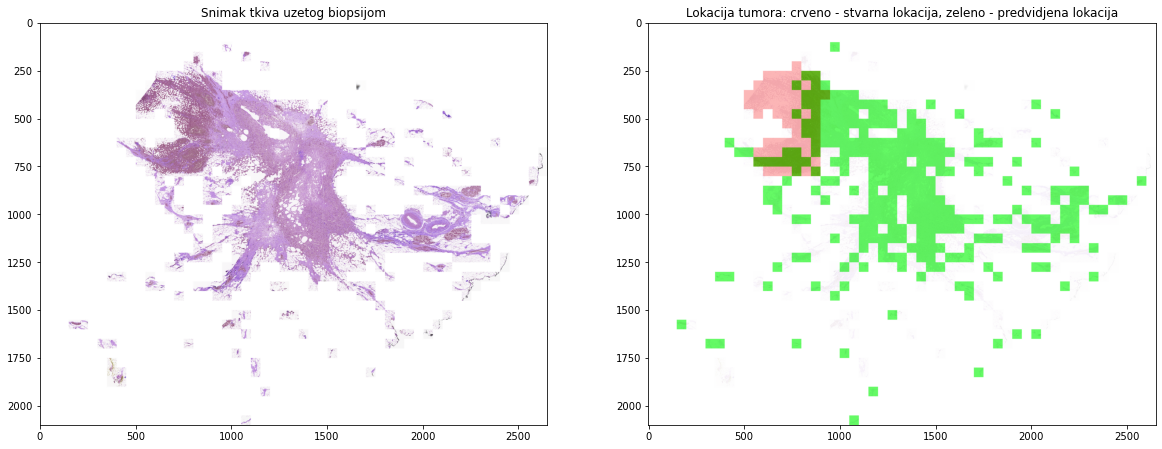

In [21]:
plot_img(10253,y_pred_svm)

### CNN

In [22]:
y_pred_cnn = cnn.predict(imgs)

In [23]:
y_pred_cnn = np.argmax(y_pred_cnn, axis = 1)

In [24]:
print(metrics.confusion_matrix(y,y_pred_cnn))

[[323 156]
 [ 12  58]]


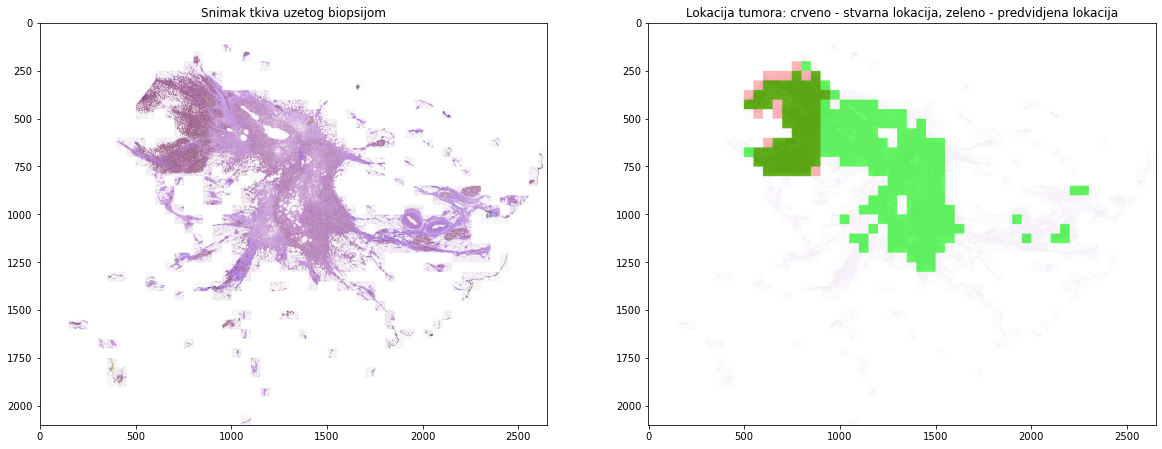

In [25]:
plot_img(10253, y_pred_cnn)